In [31]:
import numpy as np
import pandas as pd

from pandas.tseries.offsets import MonthEnd

import yfinance as yf
from pandas_datareader import data as pdr
from scipy.signal import welch
import statsmodels.api as sm


# --------------------------
# IO helpers
# --------------------------
def _to_numeric_clean(s: pd.Series) -> pd.Series:
    """Robust numeric parser for strings like '1,234.56' or ' - '."""
    return (
        s.astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("%", "", regex=False)
        .str.strip()
        .replace({"": np.nan, "nan": np.nan, "None": np.nan, "-": np.nan})
        .astype(float)
    )

def load_gold_monthly(path="Data/Gold Historical Data.csv") -> pd.Series:
    df = pd.read_csv(path)
    # handle possible date formats
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce", format="%d/%m/%Y")
    df["Price"] = _to_numeric_clean(df["Price"])
    s = df.set_index("Date")["Price"].sort_index()
    # ensure month-end index
    s.index = (s.index + MonthEnd(0))
    s = s[~s.index.duplicated(keep="last")]
    return s

def load_oil_monthly(path="Data/Crude Oil Data.csv") -> pd.Series:
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce", format="%m/%d/%Y")
    df["Value"] = _to_numeric_clean(df["Value"])
    s = df.set_index("Date")["Value"].sort_index()
    s.index = (s.index + MonthEnd(0))
    s = s[~s.index.duplicated(keep="last")]
    return s

def fetch_fred_monthly(series_ids, start="1975-01-01") -> pd.DataFrame:
    df = pdr.DataReader(series_ids, "fred", start=start)
    # align to month-end
    df = df.resample("ME").last()
    return df

def fetch_sp500_monthly(start="1975-01-01") -> pd.Series:
    px = yf.download("^GSPC", start=start, auto_adjust=True, progress=False)["Close"]
    px = px.resample("ME").last()
    px = pd.Series(px['^GSPC'], index=px.index, name="SP500")
    return px


# --------------------------
# Transform + detrend
# --------------------------
def log_level(s: pd.Series) -> pd.Series:
    s = s.dropna()
    return np.log(s)

def diff_log(s: pd.Series) -> pd.Series:
    return log_level(s).diff()

def detrend_linear(y: pd.Series) -> pd.Series:
    """
    Detrend by OLS on time index: y_t = a + b*t + e_t.
    Returns residual e_t aligned to y index.
    """
    y = y.dropna()
    t = np.arange(len(y), dtype=float)
    X = sm.add_constant(t)
    model = sm.OLS(y.values, X).fit()
    resid = pd.Series(model.resid, index=y.index, name=y.name)
    return resid

def detrend_lowess(y: pd.Series, frac=0.15) -> pd.Series:
    """
    LOWESS smooth trend, residual = y - smooth(y).
    frac controls smoothness; tune later for robustness.
    """
    y = y.dropna()
    t = np.arange(len(y), dtype=float)
    smooth = sm.nonparametric.lowess(y.values, t, frac=frac, return_sorted=False)
    resid = pd.Series(y.values - smooth, index=y.index, name=y.name)
    return resid


# --------------------------
# Spectral peak test with AR(1) null
# --------------------------
def fit_ar1_params(x: np.ndarray) -> tuple[float, float]:
    """Fit AR(1): x_t = phi*x_{t-1} + eps; return (phi, sigma_eps)."""
    x = x[~np.isnan(x)]
    x0 = x[:-1]
    x1 = x[1:]
    phi = np.dot(x0, x1) / np.dot(x0, x0)  # OLS w/o intercept on demeaned series
    eps = x1 - phi * x0
    sigma = np.std(eps, ddof=1)
    return float(phi), float(sigma)

def simulate_ar1(phi: float, sigma: float, n: int, burn=200, seed=None) -> np.ndarray:
    rng = np.random.default_rng(seed)
    x = np.zeros(n + burn)
    eps = rng.normal(0.0, sigma, size=n + burn)
    for i in range(1, n + burn):
        x[i] = phi * x[i - 1] + eps[i]
    return x[burn:]

def periodogram_dense(x, fs=1.0, nfft=4096):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    x = x - x.mean()
    # rfft gives frequencies from 0..Nyquist
    X = np.fft.rfft(x, n=nfft)
    pxx = (np.abs(X) ** 2) / len(x)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    # drop f=0 to avoid infinite period
    f, pxx = f[1:], pxx[1:]
    periods = 1.0 / f
    return periods, pxx

def welch_spectrum_dense(x, fs=1.0, nperseg=256, nfft=4096):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    x = x - x.mean()
    f, pxx = welch(x, fs=fs, nperseg=min(nperseg, len(x)), nfft=nfft, detrend=False)
    f, pxx = f[1:], pxx[1:]
    periods = 1.0 / f
    return periods, pxx

def band_peak(periods: np.ndarray, power: np.ndarray, band: tuple[float, float]) -> tuple[float, float]:
    lo, hi = band
    mask = (periods >= lo) & (periods <= hi)
    if not np.any(mask):
        return np.nan, np.nan
    idx = np.argmax(power[mask])
    p_peak = periods[mask][idx]
    pow_peak = power[mask][idx]
    return float(p_peak), float(pow_peak)

def spectral_band_test(resid: pd.Series, bands, sims=1000, seed=42) -> pd.DataFrame:
    """
    For each band: compute observed peak power and AR(1) Monte Carlo p-value.
    """
    y = resid.dropna().values.astype(float)
    n = len(y)

    # observed spectrum
    per, pow_ = periodogram_dense(y, fs=1.0)
    phi, sigma = fit_ar1_params(y - np.mean(y))

    # simulate null distribution of band peaks
    rng = np.random.default_rng(seed)
    null_peaks = {band: [] for band in bands}

    for k in range(sims):
        xsim = simulate_ar1(phi, sigma, n, seed=int(rng.integers(0, 1e9)))
        ps, xs = periodogram_dense(xsim, fs=1.0)
        for band in bands:
            _, pk = band_peak(ps, xs, band)
            null_peaks[band].append(pk)

    rows = []
    for band in bands:
        p_peak, pow_peak = band_peak(per, pow_, band)
        null = np.array(null_peaks[band], dtype=float)
        pval = (np.sum(null >= pow_peak) + 1) / (len(null) + 1)  # add-one smoothing
        rows.append({
            "band_lo_m": band[0],
            "band_hi_m": band[1],
            "peak_period_m": p_peak,
            "peak_power": pow_peak,
            "ar1_phi": phi,
            "ar1_sigma": sigma,
            "p_value_ar1": pval,
            "n_obs": n
        })
    return pd.DataFrame(rows)

In [32]:

# --------------------------
# Run: build dataset
# --------------------------
START = "1975-01-01"
BANDS = [(36, 48), (84, 132), (180, 240)]

gold = load_gold_monthly("/Users/henrywzh/Desktop/Data/Gold Historical Data.csv")
oil  = load_oil_monthly("/Users/henrywzh/Desktop/Data/Crude Oil Data.csv")

fred_ids = ["GS10", "CPIAUCSL", "PPIACO", "INDPRO", "FEDFUNDS", "BAA"]
fred = fetch_fred_monthly(fred_ids, start=START)

spx = fetch_sp500_monthly(start=START)

# align all to common month-end index
df = pd.concat([spx, gold.rename("GOLD"), oil.rename("OIL"), fred], axis=1).dropna()

# build PRIMARY residuals (log-level detrend), yields detrend on level
series_primary = {}
series_primary["SP500_loglvl_resid"] = detrend_linear(log_level(df["SP500"]))
series_primary["GOLD_loglvl_resid"]  = detrend_linear(log_level(df["GOLD"]))
series_primary["OIL_loglvl_resid"]   = detrend_linear(log_level(df["OIL"]))
series_primary["CPI_loglvl_resid"]   = detrend_linear(log_level(df["CPIAUCSL"]))
series_primary["PPI_loglvl_resid"]   = detrend_linear(log_level(df["PPIACO"]))
series_primary["IP_loglvl_resid"]    = detrend_linear(log_level(df["INDPRO"]))
series_primary["GS10_lvl_resid"]     = detrend_linear(df["GS10"])

# SECONDARY (changes)
series_secondary = {}
series_secondary["SP500_ret_m"] = diff_log(df["SP500"])
series_secondary["CPI_infl_m"]  = diff_log(df["CPIAUCSL"])
series_secondary["PPI_infl_m"]  = diff_log(df["PPIACO"])
series_secondary["IP_g_m"]      = diff_log(df["INDPRO"])

# run tests
out = []
for name, s in series_primary.items():
    res = spectral_band_test(s, BANDS, sims=500, seed=1)  # bump sims to 1000 later
    res.insert(0, "series", name)
    res.insert(1, "transform", "primary_detrended_level")
    out.append(res)

for name, s in series_secondary.items():
    res = spectral_band_test(s.dropna(), BANDS, sims=500, seed=2)
    res.insert(0, "series", name)
    res.insert(1, "transform", "secondary_changes")
    out.append(res)

results = pd.concat(out, ignore_index=True)
print(results.sort_values(["transform", "series", "band_lo_m"]))

                series                transform  band_lo_m  band_hi_m  \
9     CPI_loglvl_resid  primary_detrended_level         36         48   
10    CPI_loglvl_resid  primary_detrended_level         84        132   
11    CPI_loglvl_resid  primary_detrended_level        180        240   
3    GOLD_loglvl_resid  primary_detrended_level         36         48   
4    GOLD_loglvl_resid  primary_detrended_level         84        132   
5    GOLD_loglvl_resid  primary_detrended_level        180        240   
18      GS10_lvl_resid  primary_detrended_level         36         48   
19      GS10_lvl_resid  primary_detrended_level         84        132   
20      GS10_lvl_resid  primary_detrended_level        180        240   
15     IP_loglvl_resid  primary_detrended_level         36         48   
16     IP_loglvl_resid  primary_detrended_level         84        132   
17     IP_loglvl_resid  primary_detrended_level        180        240   
6     OIL_loglvl_resid  primary_detrended_level    

In [33]:
results.sort_values(["transform", "series", "band_lo_m"])

,series,transform,band_lo_m,band_hi_m,peak_period_m,peak_power,ar1_phi,ar1_sigma,p_value_ar1,n_obs
9,CPI_loglvl_resid,primary_detrended_level,36,48,45.010989,0.023231,0.991954,0.003026,0.001996,609
10,CPI_loglvl_resid,primary_detrended_level,84,132,128.000000,0.262358,0.991954,0.003026,0.001996,609
11,CPI_loglvl_resid,primary_detrended_level,180,240,227.555556,0.467036,0.991954,0.003026,0.001996,609
3,GOLD_loglvl_resid,primary_detrended_level,36,48,40.960000,0.368940,0.994415,0.052956,0.536926,609
4,GOLD_loglvl_resid,primary_detrended_level,84,132,91.022222,2.913193,0.994415,0.052956,0.233533,609
5,GOLD_loglvl_resid,primary_detrended_level,180,240,186.181818,5.449648,0.994415,0.052956,0.393214,609
18,GS10_lvl_resid,primary_detrended_level,36,48,44.043011,25.666528,0.983379,0.294914,0.045908,609
19,GS10_lvl_resid,primary_detrended_level,84,132,102.400000,164.792183,0.983379,0.294914,0.015968,609
20,GS10_lvl_resid,primary_detrended_level,180,240,227.555556,216.276222,0.983379,0.294914,0.105788,609
15,IP_loglvl_resid,primary_detrended_level,36,48,45.010989,0.072653,0.995569,0.009592,0.001996,609


In [34]:
from scipy.signal import find_peaks

def discover_peaks(periods, power, min_p=24, max_p=None, top_k=8):
    if max_p is None:
        max_p = min(300, np.nanmax(periods))
    mask = (periods >= min_p) & (periods <= max_p)
    P = periods[mask]
    S = power[mask]

    # peaks with a prominence threshold tied to spectrum dispersion
    prom = np.nanstd(S) * 0.5
    peaks, props = find_peaks(S, prominence=prom)

    if len(peaks) == 0:
        return []

    # rank by prominence (more robust than height)
    order = np.argsort(props["prominences"])[::-1][:top_k]
    out = [(float(P[peaks[i]]), float(S[peaks[i]]), float(props["prominences"][i])) for i in order]
    return out

def peak_pvalue_ar1_local(resid: pd.Series, peak_period_m: float, sims=1000, seed=123, band_frac=0.10):
    band = (peak_period_m * (1 - band_frac), peak_period_m * (1 + band_frac))
    # reuse your existing spectral_band_test but with a single custom band
    df = spectral_band_test(resid, [band], sims=sims, seed=seed)
    return df.iloc[0].to_dict()  # includes p_value_ar1, peak_period_m (local), etc.



In [35]:
all_peaks = []
for name, s in series_primary.items():
    s = s.dropna()
    periods, power = periodogram_dense(s.values, fs=1.0)
    peaks = discover_peaks(periods, power, min_p=24, max_p=300, top_k=5)

    for (p_m, pk_power, prom) in peaks:
        all_peaks.append({"series": name, "period_m": p_m, "power": pk_power, "prominence": prom})

peaks_df = pd.DataFrame(all_peaks)
print(peaks_df.sort_values(["prominence"], ascending=False).head(30))

                series    period_m       power  prominence
23      GS10_lvl_resid  240.941176  233.513417  197.032205
24      GS10_lvl_resid  163.840000  180.988229  156.785816
25      GS10_lvl_resid  102.400000  164.792183  145.821315
26      GS10_lvl_resid  128.000000  112.081914   70.317599
27      GS10_lvl_resid   85.333333   52.505274   47.824032
2    GOLD_loglvl_resid  170.666667    8.618938    7.857895
6     OIL_loglvl_resid  170.666667    6.994956    6.305403
3    GOLD_loglvl_resid   91.022222    2.913193    2.837565
7     OIL_loglvl_resid  124.121212    3.844382    2.648406
8     OIL_loglvl_resid   65.015873    2.377067    2.333386
9     OIL_loglvl_resid   97.523810    2.217603    1.843978
4    GOLD_loglvl_resid  124.121212    2.162317    1.728029
5    GOLD_loglvl_resid   75.851852    1.331214    0.981703
13    PPI_loglvl_resid  163.840000    0.793560    0.772411
0   SP500_loglvl_resid   97.523810    0.924783    0.656726
1   SP500_loglvl_resid   41.373737    0.592136    0.5912

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import statsmodels.api as sm

# -----------------------------
# 1) Detrend helpers
# -----------------------------
def detrend_linear(y: pd.Series) -> pd.Series:
    y = y.dropna()
    t = np.arange(len(y), dtype=float)
    X = sm.add_constant(t)
    resid = sm.OLS(y.values, X).fit().resid
    return pd.Series(resid, index=y.index, name=y.name)

def detrend_lowess(y: pd.Series, frac: float = 0.15) -> pd.Series:
    y = y.dropna()
    t = np.arange(len(y), dtype=float)
    smooth = sm.nonparametric.lowess(y.values, t, frac=frac, return_sorted=False)
    return pd.Series(y.values - smooth, index=y.index, name=y.name)

def zscore_series(y: pd.Series) -> pd.Series:
    y = y.dropna()
    return (y - y.mean()) / y.std(ddof=0)

# -----------------------------
# 2) Dense periodogram (FFT)
# -----------------------------
def periodogram_dense(x: np.ndarray, fs: float = 1.0, nfft: int = 8192):
    """
    Dense periodogram. fs=1 for monthly.
    Returns (periods_in_months, power).
    """
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    x = x - x.mean()

    X = np.fft.rfft(x, n=nfft)
    power = (np.abs(X) ** 2) / len(x)

    f = np.fft.rfftfreq(nfft, d=1/fs)
    # drop f=0 -> infinite period
    f, power = f[1:], power[1:]
    periods = 1.0 / f
    return periods, power

# -----------------------------
# 3) Discover peaks (no preset periods)
# -----------------------------
def discover_peaks(periods, power, n_obs, min_p=24, max_p=None, top_k=6, prom_sigma=0.5):
    """
    Find top peaks by prominence in [min_p, max_p].
    max_p defaults to min(160, n_obs/2) for ~2-cycle reliability.
    """
    if max_p is None:
        max_p = min(160, n_obs // 2)

    mask = (periods >= min_p) & (periods <= max_p)
    P = periods[mask]
    S = power[mask]

    # normalize spectrum for comparability across series
    S = S / np.nansum(S)

    # prominence threshold tied to dispersion
    prom = np.nanstd(S) * prom_sigma
    peaks, props = find_peaks(S, prominence=prom)

    if len(peaks) == 0:
        return P, S, []

    # rank by prominence
    order = np.argsort(props["prominences"])[::-1]
    order = order[:top_k]

    out = []
    for i in order:
        idx = peaks[i]
        out.append({
            "period_m": float(P[idx]),
            "power_norm": float(S[idx]),
            "prominence": float(props["prominences"][i])
        })
    return P, S, out

# -----------------------------
# 4) Plot spectrum + peaks
# -----------------------------
def plot_spectrum_with_peaks(
    resid: pd.Series,
    title: str,
    nfft: int = 8192,
    min_p: float = 24,
    max_p: float | None = None,
    top_k: int = 6,
    show_refs: bool = True
):
    x = resid.dropna().values
    n_obs = len(x)

    periods, power = periodogram_dense(x, fs=1.0, nfft=nfft)
    P, S_norm, peaks = discover_peaks(periods, power, n_obs, min_p=min_p, max_p=max_p, top_k=top_k)

    plt.figure(figsize=(11, 5))
    plt.plot(P, S_norm)
    plt.yscale("log")  # spectrum usually easier to read in log scale

    # mark peaks
    if peaks:
        pp = [d["period_m"] for d in peaks]
        ss = [d["power_norm"] for d in peaks]
        plt.scatter(pp, ss)
        for d in peaks:
            plt.text(d["period_m"], d["power_norm"], f"{d['period_m']:.1f}m", fontsize=9)

    # optional reference lines (42/100/200)
    if show_refs:
        for ref in [42, 100, 200]:
            if (ref >= min_p) and ((max_p is None) or (ref <= max_p)):
                plt.axvline(ref, linestyle="--")

    plt.xlabel("Period (months)")
    plt.ylabel("Normalized power (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return peaks


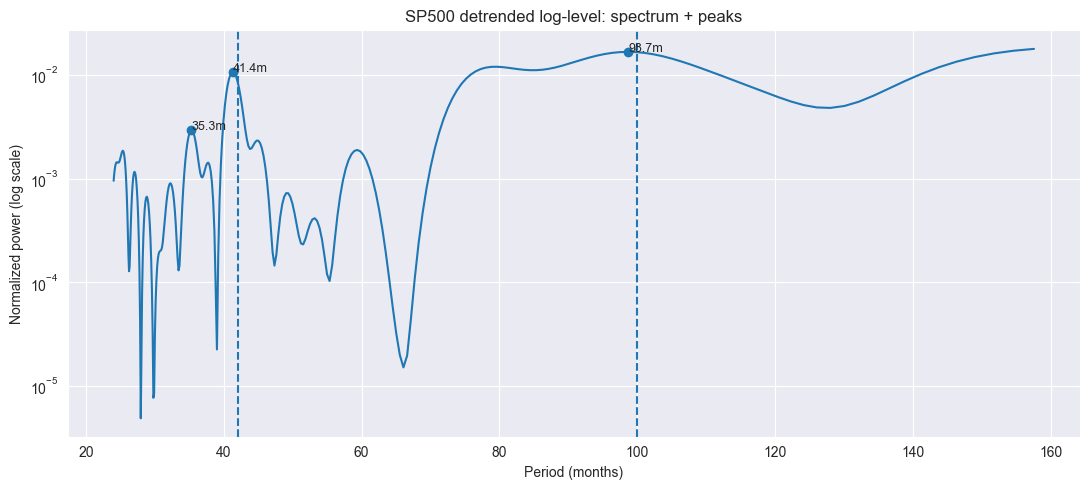

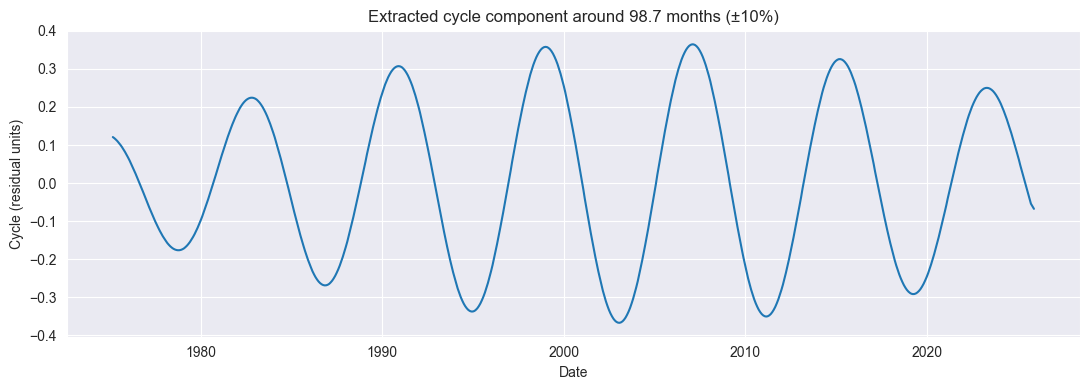

In [44]:
def extract_cycle_fft(resid: pd.Series, target_period_m: float, band_frac: float = 0.10, nfft: int = 8192):
    """
    Extract a band-pass component around target_period_m using FFT filtering.
    band_frac=0.10 -> keep periods in [0.9T, 1.1T].
    """
    y = resid.dropna()
    x = y.values.astype(float)
    n = len(x)
    x = x - x.mean()

    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1.0)  # monthly, fs=1
    # avoid f=0 bin already implicit in rfft; keep it at 0
    periods = np.zeros_like(f)
    periods[1:] = 1.0 / f[1:]
    periods[0] = np.inf

    lo = target_period_m * (1 - band_frac)
    hi = target_period_m * (1 + band_frac)

    band_mask = (periods >= lo) & (periods <= hi)
    # keep only the selected band
    X_filt = X * band_mask

    cycle = np.fft.irfft(X_filt, n=nfft)[:n]
    cycle = pd.Series(cycle, index=y.index, name=f"cycle_{target_period_m:.1f}m")
    return cycle

def plot_cycle_component(resid: pd.Series, target_period_m: float, band_frac: float = 0.10):
    cycle = extract_cycle_fft(resid, target_period_m, band_frac=band_frac)

    plt.figure(figsize=(11, 4))
    plt.plot(cycle.index, cycle.values)
    plt.title(f"Extracted cycle component around {target_period_m:.1f} months (±{band_frac*100:.0f}%)")
    plt.xlabel("Date")
    plt.ylabel("Cycle (residual units)")
    plt.tight_layout()
    plt.show()

    return cycle

def zscore_series(y: pd.Series) -> pd.Series:
    y = y.dropna()
    return (y - y.mean()) / y.std(ddof=0)

# 1) Suppose you have a raw monthly level series, e.g. df["SP500"]
spx_log = np.log(df["SP500"])
spx_resid = detrend_linear(spx_log)
spx_resid = zscore_series(spx_resid)

# 2) Visualize spectrum and get discovered peaks
peaks = plot_spectrum_with_peaks(spx_resid, "SP500 detrended log-level: spectrum + peaks", max_p=160)

# 3) Pick the top peak and plot the corresponding cycle in time domain
if peaks:
    T = peaks[0]["period_m"]
    plot_cycle_component(spx_resid, T, band_frac=0.10)

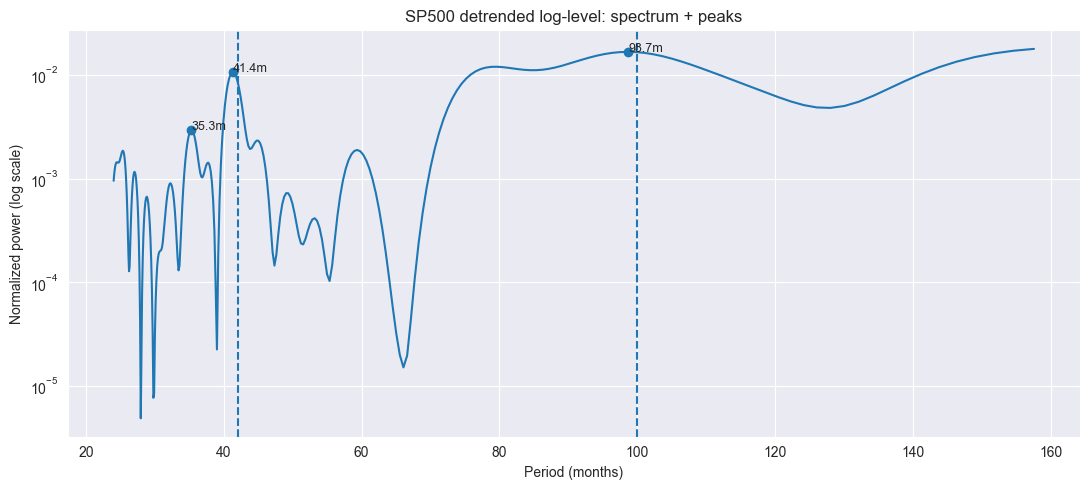

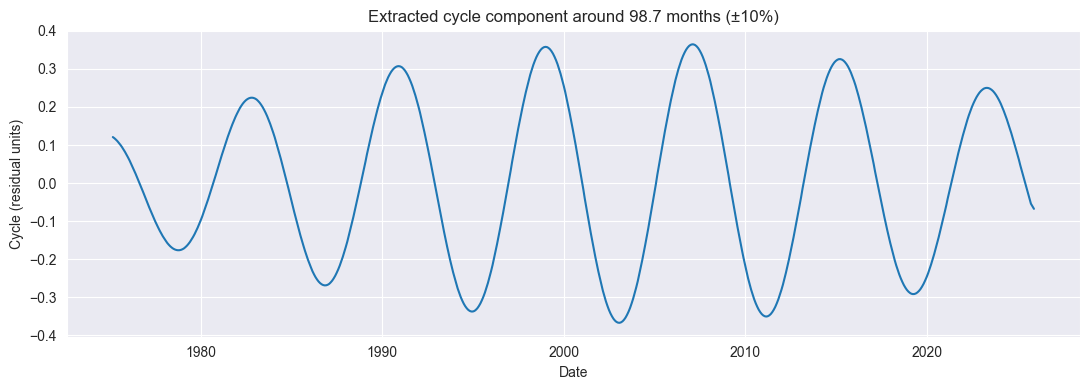

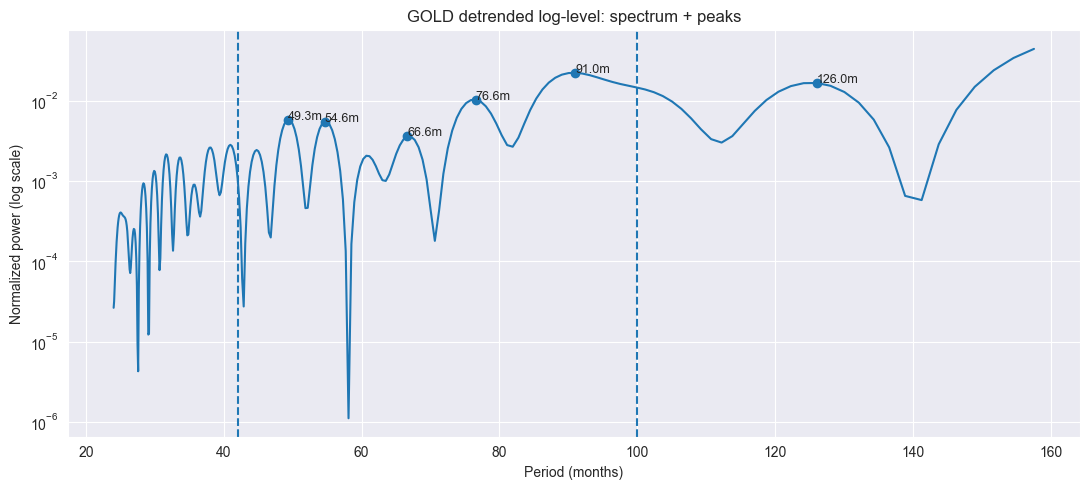

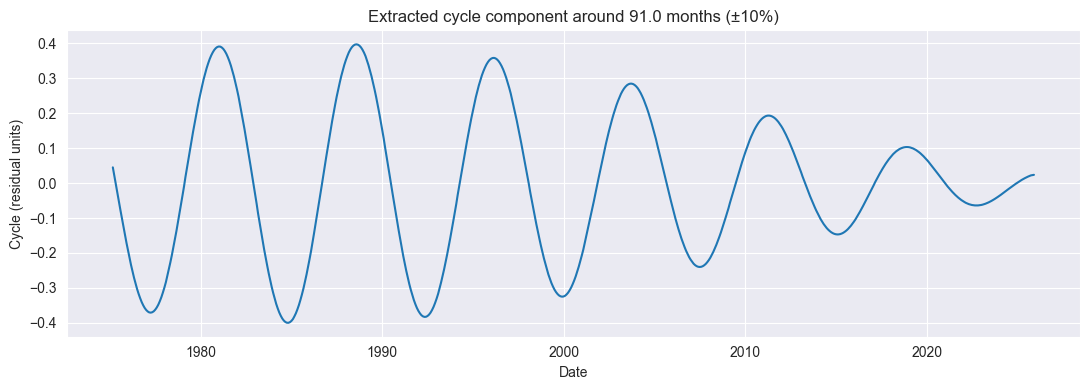

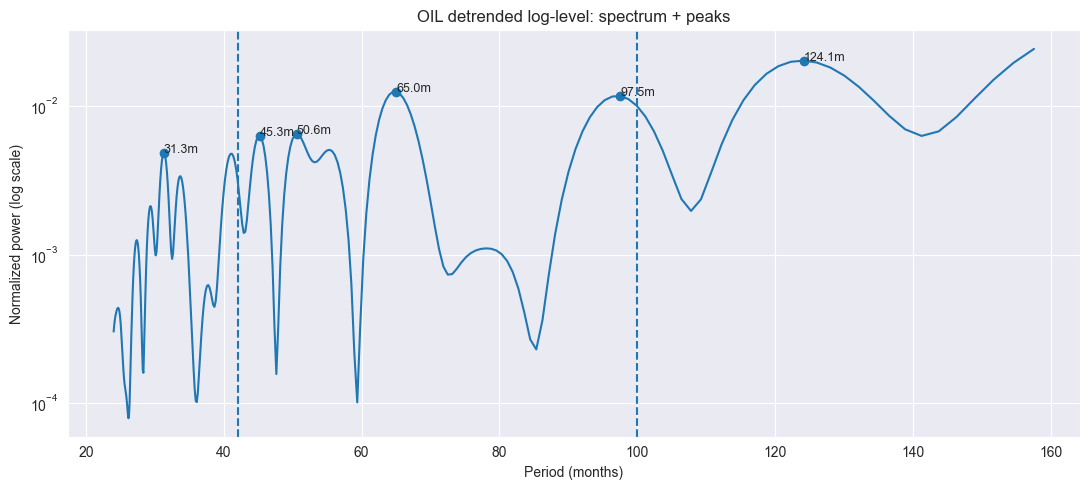

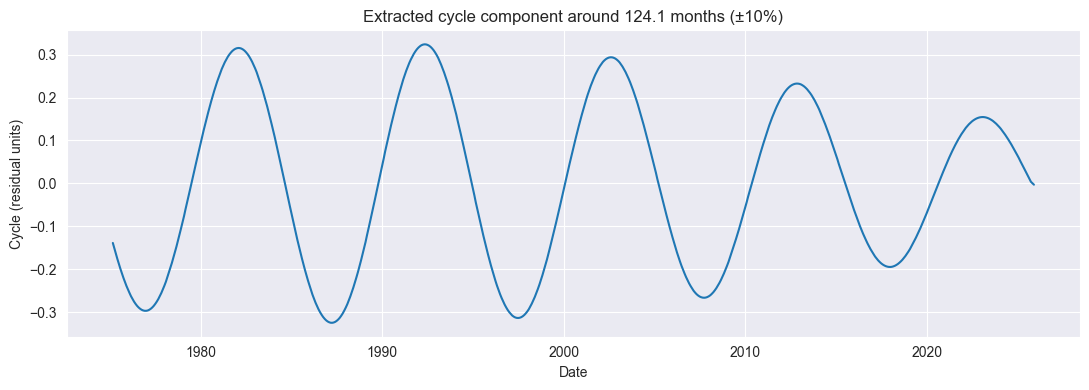

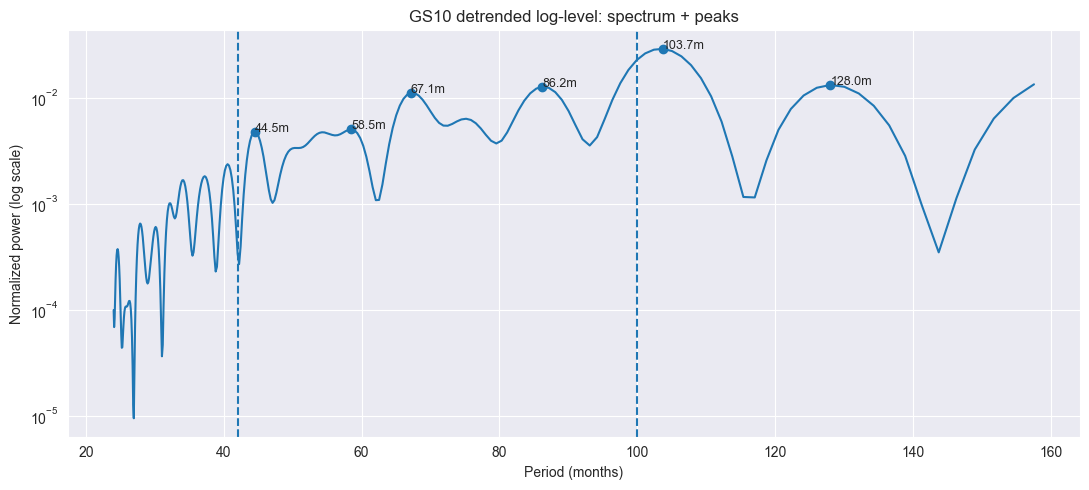

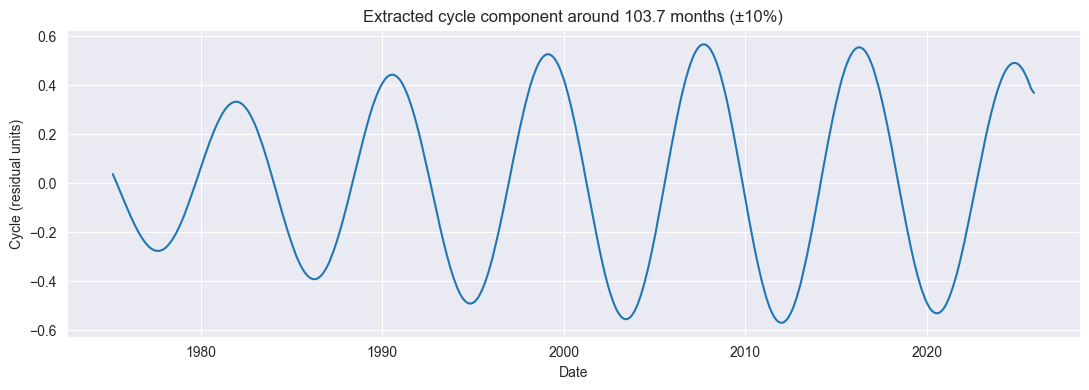

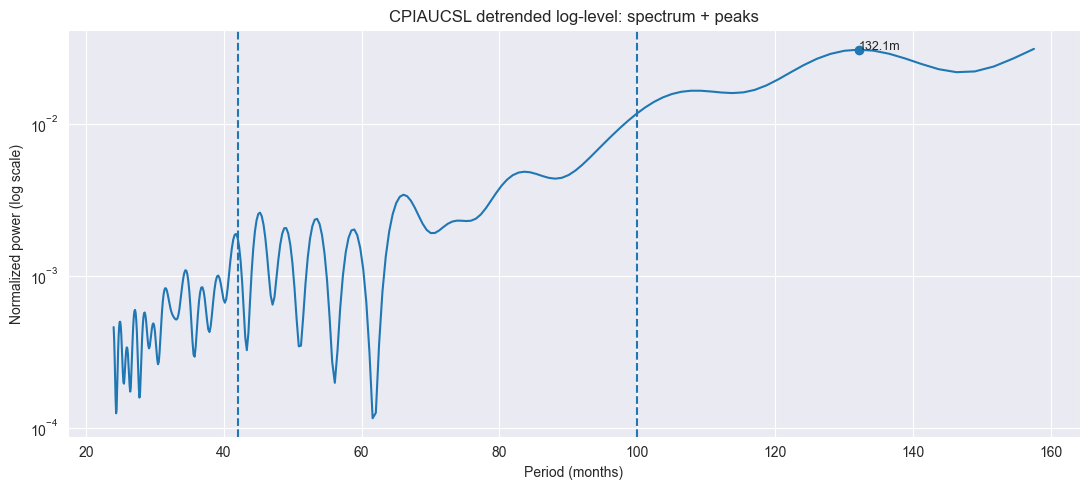

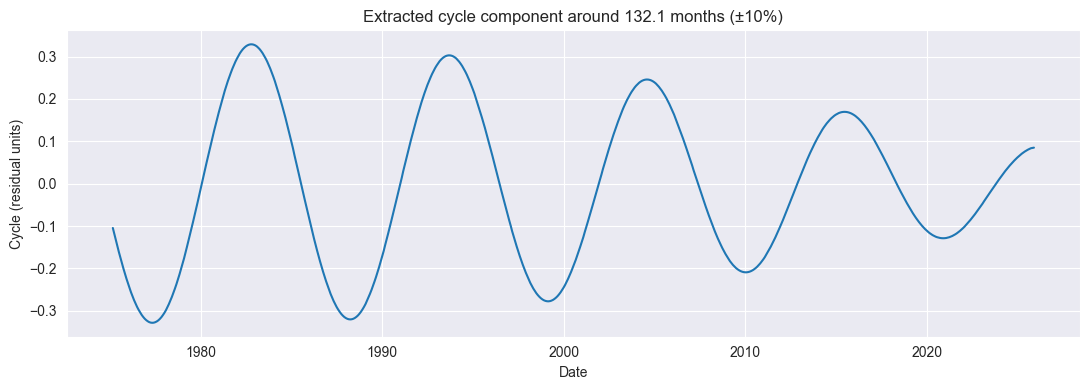

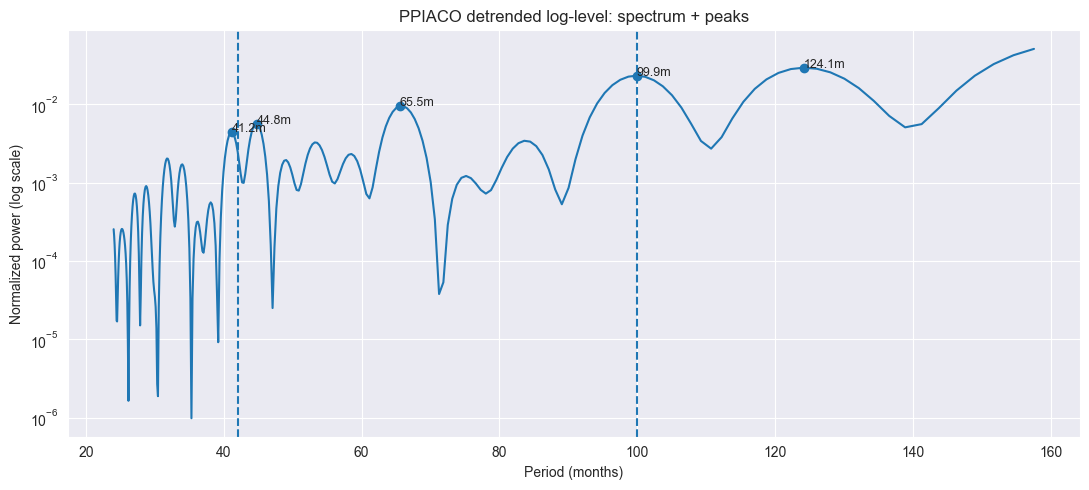

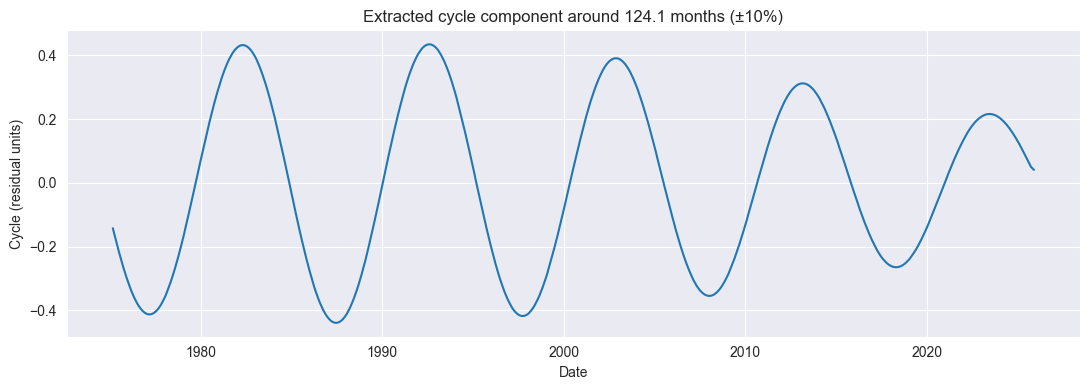

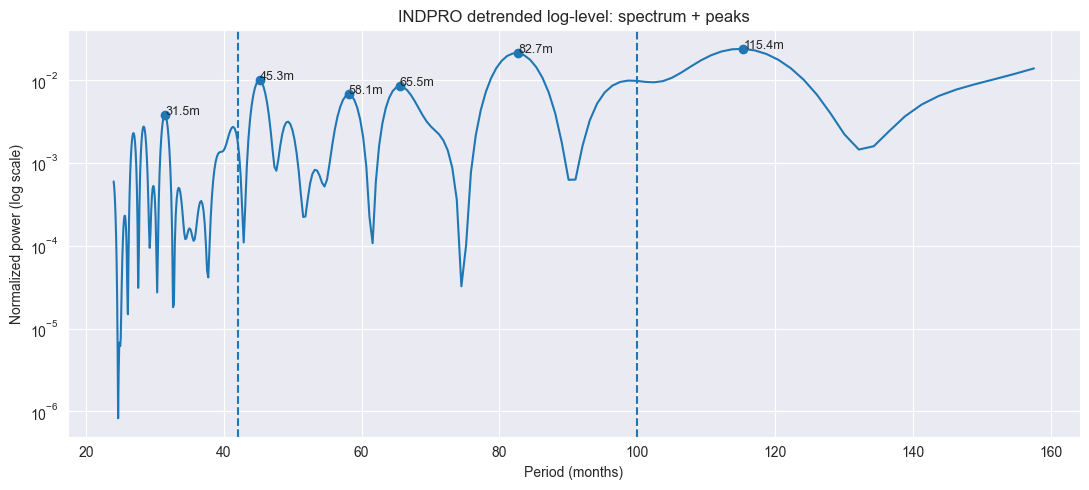

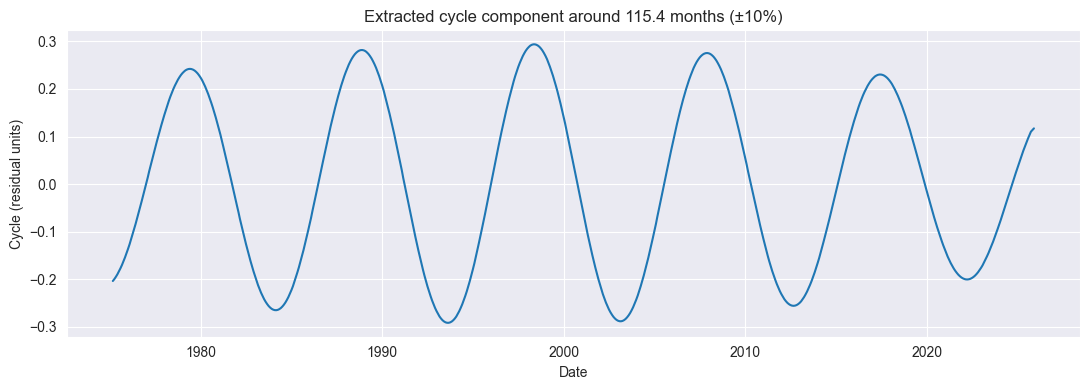

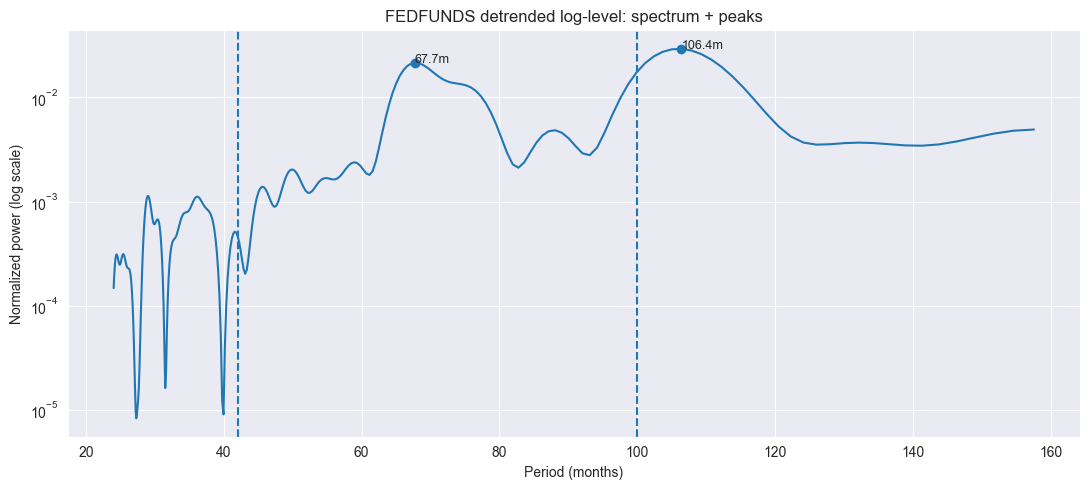

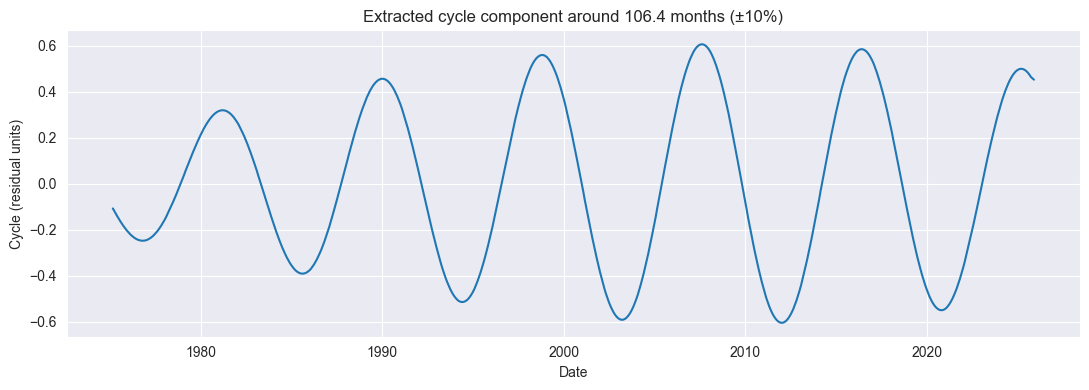

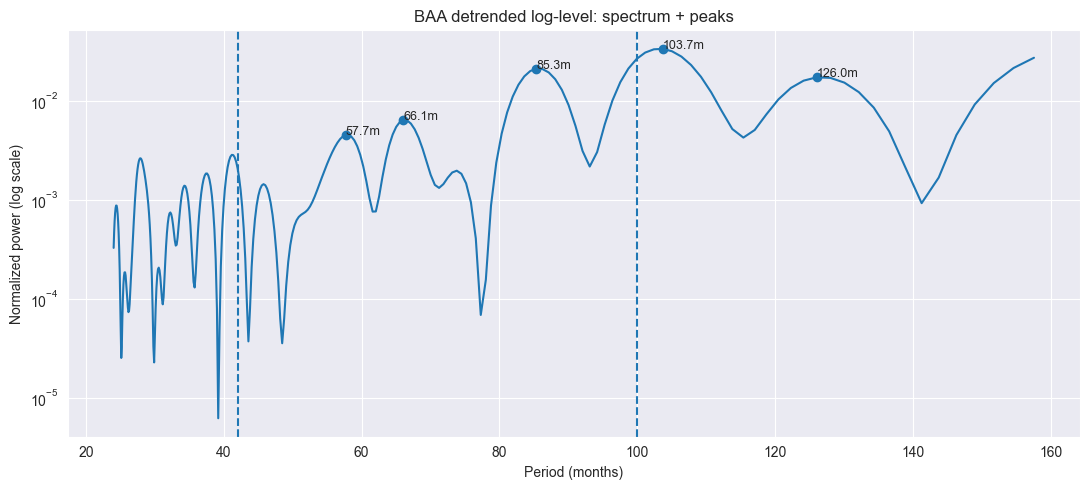

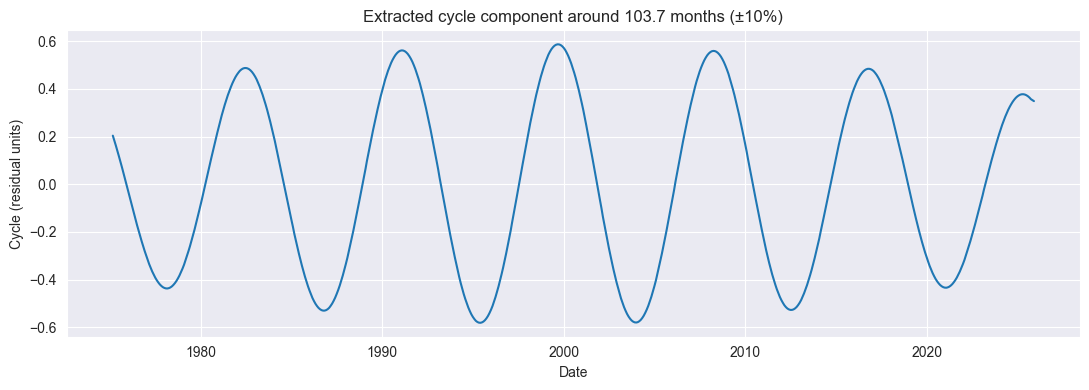

In [48]:
for k in df.columns:
    # 1) Suppose you have a raw monthly level series, e.g. df["SP500"]
    spx_log = np.log(df[k])
    spx_resid = detrend_linear(spx_log)
    spx_resid = zscore_series(spx_resid)
    
    # 2) Visualize spectrum and get discovered peaks
    peaks = plot_spectrum_with_peaks(spx_resid, f"{k} detrended log-level: spectrum + peaks", max_p=160)
    
    # 3) Pick the top peak and plot the corresponding cycle in time domain
    if peaks:
        T = peaks[0]["period_m"]
        plot_cycle_component(spx_resid, T, band_frac=0.10)

<Axes: >

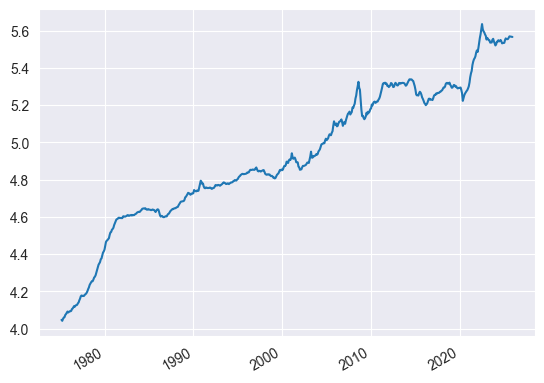

In [51]:
log_level(df["PPIACO"]).plot()